In [1]:
%pylab inline
%matplotlib inline
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/Users/Argen/Documents/MAS/R&D/Code/pgm'])

Populating the interactive namespace from numpy and matplotlib
Python 2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)] on darwin


In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

In [3]:
import numpy as np
from itertools import combinations, product, izip
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
import pandas as pd

In [6]:
import copy

In [7]:
from pgm.utils.tools import draw_graph, node_types
from pgm.nodes.chance import Chance
from pgm.nodes.decision import Decision
from pgm.nodes.utility import Utility

# Influence Diagram

## Definition

In [8]:
a = Chance('A')
b = Chance('B')
c = Chance('C')
d = Chance('D')
e = Chance('E')
f = Chance('F')
g = Chance('G')
h = Chance('H')
i = Chance('I')
j = Chance('J')
k = Chance('K')
l = Chance('L')

d1 = Decision('D1')
d2 = Decision('D2')
d3 = Decision('D3')
d4 = Decision('D4')

v1 = Utility('V1')
v2 = Utility('V2')
v3 = Utility('V3')
v4 = Utility('V4')

chance = [a, b, c, d, e, f, g, h, i, j, k, l]
decision = [d1, d2, d3, d4]
utility = [v1, v2, v3, v4]

edges = [(a, c), (b, c), (b, d1), (b, d), (d1, v1), (d1, d),
         (c, e), (d, e), (d, f), (e, g), (e, d2), (f, d2), (f, h),
         (g, d4), (g, i), (d2, i), (d2, d3), (h, k), (h, j), (d3, k), (d3, v2), (d3, d4),
         (d4, l), (i, l), (j, v3), (k, v3), (l, v4)]
nodes = []
nodes.extend(chance)
nodes.extend(decision)
nodes.extend(utility)

In [9]:
net = nx.DiGraph(title='influence_diagram')

id_nodes = [n.node for n in nodes]
id_edges = [(e[0].name, e[1].name) for e in edges]

net.add_nodes_from(id_nodes)
net.add_edges_from(id_edges, type='causal')

node_dict = node_types(net)
chance, decision, utility = node_dict.get('chance'), node_dict.get('decision'), node_dict.get('utility')

for n in net.nodes():
    ed = net.in_edges([n])
    if net.node[n]['type'] is 'chance':
        net.add_edges_from(ed, type='conditional')
    elif net.node[n]['type'] is 'decision':
        net.add_edges_from(ed, type='informational')
    elif net.node[n]['type'] is 'utility':
        net.add_edges_from(ed, type='functional')
#    'functional'
#    'conditional'
#    'informational'

# print net.nodes(data=True)
# print net.edges(data=True)

other


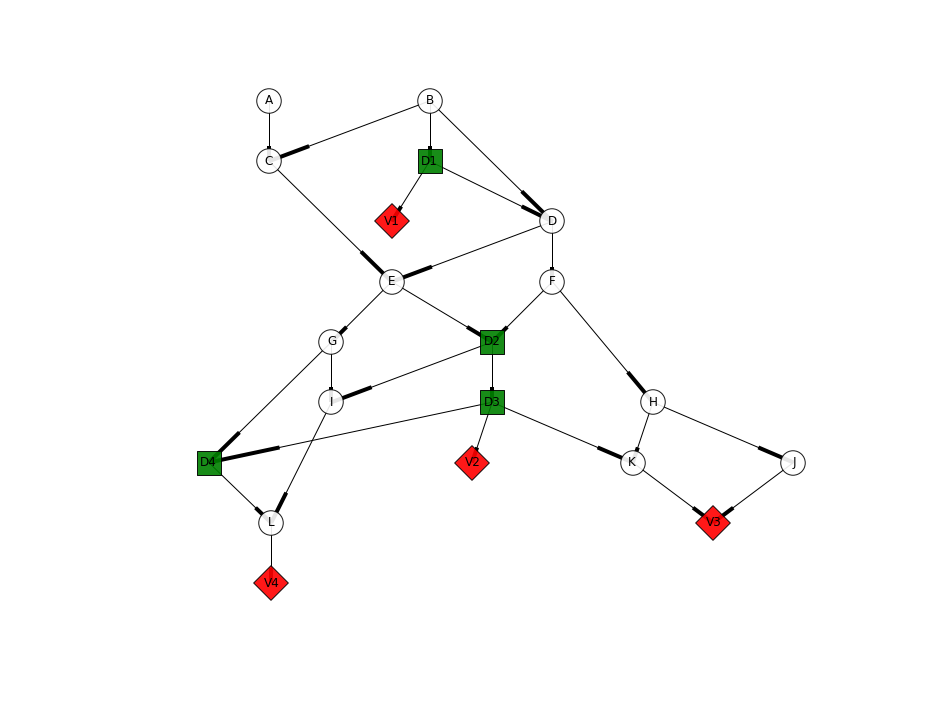

In [10]:
pos = nx.graphviz_layout(net, prog='dot')
draw_graph(net, pos)

###Tables

#### Conditional Probability Table

In [11]:
def cpt(graph, node, data):
    domain = graph.node[node]['domain']
    n = 1
    m = len(domain)
    
    parents = graph.predecessors(node)
    
    parents_names = []
    parents_domains = []  
    
    rows = pd.MultiIndex.from_product([domain], names=[node])
    
    for parent in parents:
            dom = graph.node[parent]['domain']
            n = n * len(dom)
            parents_names.append(parent)
            parents_domains.append(dom)
    
    if parents and data.shape == (m,n):
        values = data
    elif not parents and (data.shape ==(m,) or data.shape == (m,1)):
        values = data.flatten()
    else:
        print 'Data error, shape should be (%i,%i)'%(m, n)
        values = np.zeros((m,n))
    
    if parents:
        cols = pd.MultiIndex.from_product(parents_domains, names=parents_names)
        table = pd.DataFrame(values, index=rows, columns=cols)
    else:
        table = pd.Series(values, index=rows,name=node)
    return table



#### Utility table

In [12]:
def ut(graph, node, data):
    m = 1
    n = 1
    
    parents = graph.predecessors(node)
    
    parents_names = []
    parents_domains = []
    
    for parent in parents:
        dom = graph.node[parent]['domain']
        m = m * len(dom)
        parents_names.append(parent)
        parents_domains.append(dom)
    
    cols = pd.MultiIndex.from_product([node], names=[node])
    rows = pd.MultiIndex.from_product(parents_domains, names=parents_names)

    if data.shape == (m,) or data.shape== (m,1):
        values = data
    else:
        print 'Data error, shape should be (%i,).'%(m,)
        print 'Data shape: ', data.shape
        values = np.zeros((m,1))
    #table = pd.DataFrame(values, index=rows, columns=cols)
    table = pd.Series(values.flatten(),index=rows, name=node)
    return table

In [13]:
a = cpt(net, 'A', np.array([[0.8,0.2]]).T)
b = cpt(net, 'B', np.array([[0.5,0.5]]).T)
c = cpt(net, 'C', np.array([[0.7,0.3], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
d = cpt(net, 'D', np.array([[0.5,0.5], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
e = cpt(net, 'E', np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
f = cpt(net, 'F', np.array([[0.6,0.4],[0.25,0.75]]).T)
g = cpt(net, 'G', np.array([[0.3,0.7],[0.25,0.75]]).T)
h = cpt(net, 'H', np.array([[0.5,0.5], [0.25,0.75]]).T)
i = cpt(net, 'I', np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
j = cpt(net, 'J', np.array([[0.3,0.7],[0.25,0.75]]).T)
k = cpt(net, 'K', np.array([[0.8,0.2], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)
l = cpt(net, 'L', np.array([[0.9,0.1], [0.6,0.4],[0.3,0.7],[0.25,0.75]]).T)

v1 = ut(net, 'V1', np.array([[10, 5]]).T)
v2 = ut(net, 'V2', np.array([[100, 50]]).T)
v3 = ut(net, 'V3', np.array([[30, 45, 80, 120]]).T)
v4 = ut(net, 'V4', np.array([[90, 70]]).T)

tables = [a,b,c,d,e,f,g,h,i,j,k,l,v1,v2,v3,v4]
node_table = ['A','B','C','D','E','F','G','H','I','J','K','L','V1','V2','V3','V4']

In [14]:
def add_tables(graph, nodes, tables):
    assert len(tables) == len(nodes)
    nx.set_node_attributes(graph, 'table', dict(zip(nodes,tables)))
        
add_tables(net, node_table, tables)   

#### Validation

In [15]:
# TODO: Check cpt and ut size
def validate(graph, verbose=False):
    for n, d in graph.nodes_iter(data=True):
        if d['type'] is 'chance':
            if not (d['table'].sum()==1).all():
                print 'Probability table in node %s should sum 1.'%n
                return False            
            x = 1
            parents = graph.predecessors(n)
            for parent in parents:
                dom = graph.node[parent]['domain']
                x = x * len(dom)
            if parents and not d['table'].shape ==(len(d['domain']), x):
                print 'Error in node %s'%n
                return False
            elif not parents and not d['table'].shape ==(len(d['domain']),):
                print 'Error in node %s'%n
                return False
            
        if d['type'] is 'utility':
            m = 1
            parents = graph.predecessors(n)
            for parent in parents:
                dom = graph.node[parent]['domain']
                m = m * len(dom)
            if not d['table'].shape ==(m, 1):
                print 'Error in node %s'%n
                return False
    return True

'''def validate(graph, verbose=False):
        for n in graph.nodes():
            if verbose:
                print '----------'
                # print n
                # print 'Parents: ' + graph.predecessors(n).__str__()
                # print 'Children: ' + graph.successors(n).__str__()
                print '%s -> %s -> %s' %(graph.predecessors(n).__str__(), n, graph.successors(n).__str__())
                if not graph.is_directed():
                    print 'Neighbors: ' + graph.neighbors(n).__str__()
                print '----------'
                # print
        print 'ID is validated.'
'''        
validate(net, True)

True

## Partial Temporal Order

In [16]:
des = []
observed = []

windows = {}
order = {}


# Sort decision orders
for d in decision:
    pred = list(set(nx.ancestors(net, d)) & set(decision))
    des.insert(len(pred), d)
    n = len(pred) * 2
    parents = net.predecessors(d)
    observed.extend(parents)
    windows[n + 1] = [d]
    windows[n] = list(set(parents).difference(set(decision)))
    order[d] = n + 1
    order.update({p: n for p in parents})
n = max(order.values()) + 1
unobserved = list(set(chance).difference(observed))
order.update({u: n for u in unobserved})
windows.update({n: unobserved})
print 'Order: ', order
print 'Windows: ', windows

Order:  {'A': 8, 'C': 8, 'B': 0, 'E': 2, 'D': 8, 'G': 6, 'F': 2, 'I': 8, 'H': 8, 'K': 8, 'J': 8, 'L': 8, 'D4': 7, 'D2': 4, 'D3': 5, 'D1': 1}
Windows:  {0: ['B'], 1: ['D1'], 2: ['E', 'F'], 3: ['D2'], 4: [], 5: ['D3'], 6: ['G'], 7: ['D4'], 8: ['A', 'C', 'D', 'I', 'H', 'K', 'J', 'L']}


##### Function

In [17]:
order

{'A': 8,
 'B': 0,
 'C': 8,
 'D': 8,
 'D1': 1,
 'D2': 4,
 'D3': 5,
 'D4': 7,
 'E': 2,
 'F': 2,
 'G': 6,
 'H': 8,
 'I': 8,
 'J': 8,
 'K': 8,
 'L': 8}

### Moralize

In [18]:
def moralize(digraph, order):
    G = digraph.copy()
    G.graph['title']= 'moral_steps'
    
    nd = node_types(G)
    c, d, u = nd.get('chance'), nd.get('decision'), nd.get('utility')
    
    # Remove information links
    for n in d:
        for p in digraph.predecessors(n):
            G.remove_edge(p, n)
            
    # Add moral links
    moral_edges = []
    for n in digraph.nodes_iter():
        arcs = list(combinations(G.predecessors(n), 2))
        # print n, arcs
        for p1,p2 in arcs:
            if (p1, p2) in digraph.edges():
                G.add_edge(p1,p2,digraph.get_edge_data(p1,p2))
                # moral_edges.append(a)
            elif (p2,p1) in digraph.edges():
                G.add_edge(p2,p1,digraph.get_edge_data(p2,p1))
                # moral_edges.append(a[::-1])
            else:
                if order.get(p1) <= order.get(p2):
                    print p1, order.get(p1), p2, order.get(p2)
                    moral_edges.append((p1,p2))
                    #G.add_edge(p1,p2, type='moral')
                elif order.get(p1) > order.get(p2):
                    print p2, order.get(p2), p1, order.get(p1)
                    moral_edges.append((p2,p1))
                    # G.add_edge(p2,p1, type='moral')
                    
                
    #print moral_edges
    #G.add_edges_from(moral_edges, type='moral')
    #print G.edges()
    # Convert to undirected graph
    #moralgraph = G.to_undirected()
    moralgraph = nx.Graph(title='moral_graph', type='moral')
    moralgraph.add_nodes_from(G.nodes(data=True))
    moralgraph.add_edges_from(G.edges(data=True))
    moralgraph.add_edges_from(moral_edges, type='moral')
    #print moralgraph.edges()
    
    #moralgraph.graph['title']='moral_graph'
    #moralgraph.graph['type']='moral'
        
    # Remove utility nodes
    moralgraph.remove_nodes_from(utility)
    return moralgraph

B 0 A 8
C 8 D 8
D2 4 G 6
D3 5 H 8
D4 7 I 8
K 8 J 8
[('A', 'C'), ('A', 'B'), ('C', 'B'), ('C', 'E'), ('C', 'D'), ('B', 'D'), ('B', 'D1'), ('E', 'D'), ('E', 'G'), ('D', 'D1'), ('D', 'F'), ('G', 'I'), ('G', 'D2'), ('F', 'H'), ('I', 'D4'), ('I', 'D2'), ('I', 'L'), ('H', 'K'), ('H', 'J'), ('H', 'D3'), ('K', 'J'), ('K', 'D3'), ('L', 'D4')]
moral


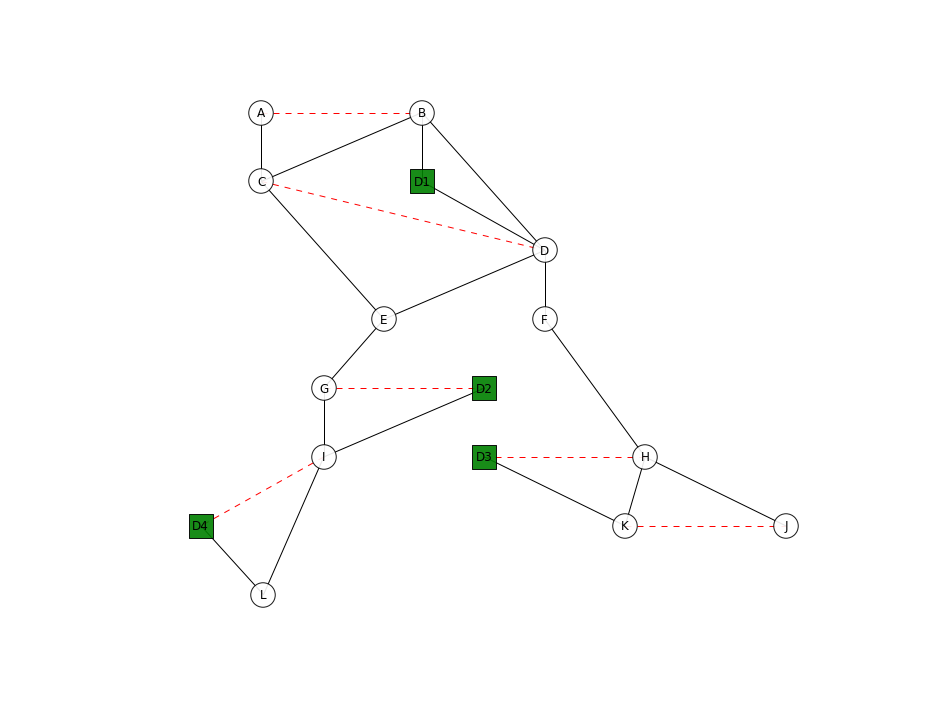

In [19]:
moral = moralize(net, order)
# print nx.get_edge_attributes(moral, 'type')
print moral.edges()
draw_graph(moral, pos)

### Triangulated Graph

In [20]:
def sp(x):
    return len(moral.node[x]['domain'])

def sz(V):
    s = 1
    for v in V:
        s = s * sp(v)
    return s

def fa(g, x, data=False):
    f = [x]
    if data:
        for n in g.neighbors(x[0]):
            f.append((n, g.node[n]))
        return f
    else:
        f.extend(g.neighbors(x))
        return f

def nb(g, x, data=False):
    neigh = []
    if data:
        for n in g.neighbors(x[0]):
            neigh.append((n, g.node[n]))
        return neigh
    else:
        return g.neighbors(x)

def is_simplicial(g, x):
    f = fa(g, x)
    n = nb(g, x)
    s = g.subgraph(f)
    if len(n)>1:
        t = []
        for e1, e2 in list(combinations(n, 2)):
            if g.has_edge(e1, e2) or g.has_edge(e2, e1):
                t.append(True)
            else:
                t.append(False)
        if sum(t) == len(t):
            return True
        else:
            return False
    else:
        return True



In [21]:
def triangulate(ugraph):
    t = ugraph.copy()
    fill_ins = []
    cliques = []
    
    for n, w in sorted(windows.items(), reverse=True):
        size = {}
        for i in w:
            size[i] = sz(fa(t, i))
    
        while size != {}:
            # Remove simplicial nodes
            simplicial = [n for n in size if is_simplicial(t, n)]
    
            if len(simplicial) > 0:
                for n in simplicial:
                    f = fa(t,n)
                    subset = filter(lambda x: set(f)< set(x), cliques)
                    if subset == []:
                        cliques.append(f)
                    t.remove_node(n)
                    size.pop(n)
            else:
                for i in size:
                    size[i] = sz(fa(t, i))
    
                if len(size) > 0:
                    candidate = min(size, key=size.get)
                    neigh = nb(t, candidate)
    
                    fill = []
                    # TODO: Algo esta mal con los cliques
                    for e1, e2 in list(combinations(neigh, 2)):
                        if not t.has_edge(e1, e2) or not t.has_edge(e2, e1):
                            t.add_edge(e1, e2)
                            fill_ins.append((e1, e2))
                            
                    f = fa(t,candidate)
                    subset = filter(lambda x: set(f)< set(x), cliques)
                    if subset == []:
                        cliques.append(f)
                    t.remove_node(candidate)
                    size.pop(candidate)
    
            # draw_graph(t, pos_ex)
    triangulated = ugraph.copy()
    triangulated.add_edges_from(fill_ins, type='triangulated')
    triangulated.graph['type']='triangulated'
    return triangulated

triangulated


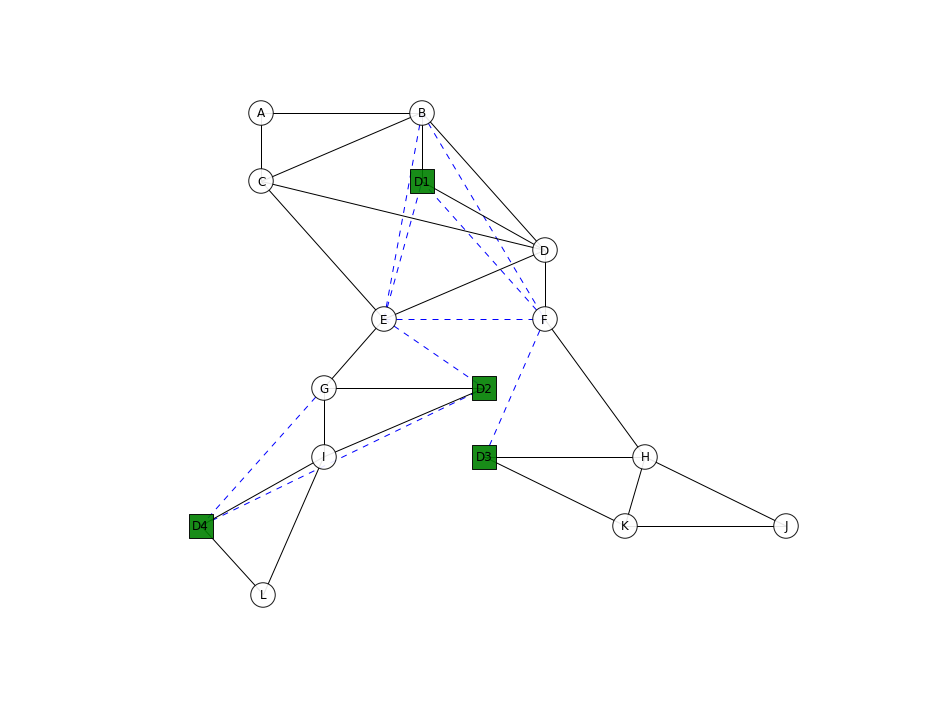

In [22]:
triangulated = triangulate(moral)
draw_graph(triangulated, pos)

triangulated


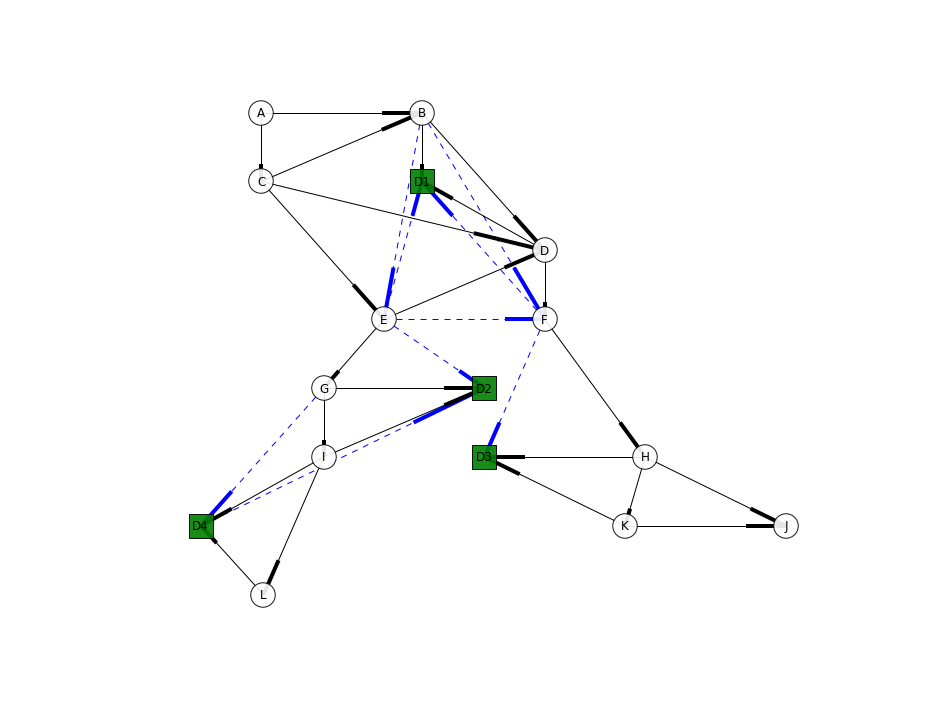

In [23]:
dir_chord_graph = nx.DiGraph(type='triangulated')
dir_chord_graph.add_nodes_from(triangulated.nodes(data=True))
dir_chord_graph.add_edges_from(triangulated.edges(data=True))


draw_graph(dir_chord_graph, pos)

### Junction Tree

In [24]:
def to_jointree(graph):
    G = graph.copy()
    cliques = [tuple(c) for c in nx.find_cliques(G)]
    edges = []
    for u, v in list(combinations(cliques, 2)):
        w = len(set(u).intersection(set(v)))
        if w >0:
            edges.append((u, v,-w))
    clique_graph = nx.Graph(title='clique_graph', type='clique')
    clique_graph.add_nodes_from(cliques)
    clique_graph.add_weighted_edges_from(edges)
    mst = nx.minimum_spanning_tree(clique_graph)
    
    #p = nx.graphviz_layout(mst, prog='dot')
    #nx.draw_networkx_edge_labels(mst, p)
    #nx.draw_networkx(mst, p)

    join_tree = nx.Graph(name = '', type='join_tree')
    join_tree.add_nodes_from(mst.nodes(), type='clique')
    join_tree.add_edges_from(mst.edges())
    return join_tree

def to_junctiontree(graph):
    join_tree = to_jointree(graph) 
    junction_tree = nx.Graph(join_tree, type='junction_tree')

    for u, v in junction_tree.edges():
        junction_tree.add_edge(u, v, separator=tuple(set(u).intersection(set(v))), u_in=0, u_out=0, p_in=1, p_out=1)
    return junction_tree



join_tree


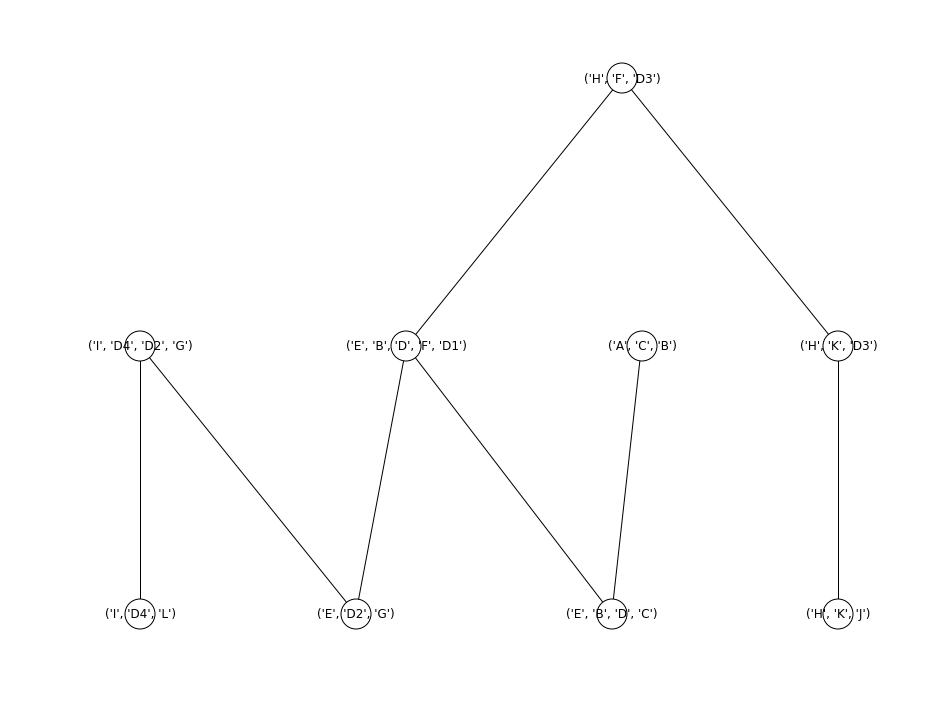

In [25]:
join_tree = to_jointree(triangulated)
draw_graph(join_tree)

junction_tree


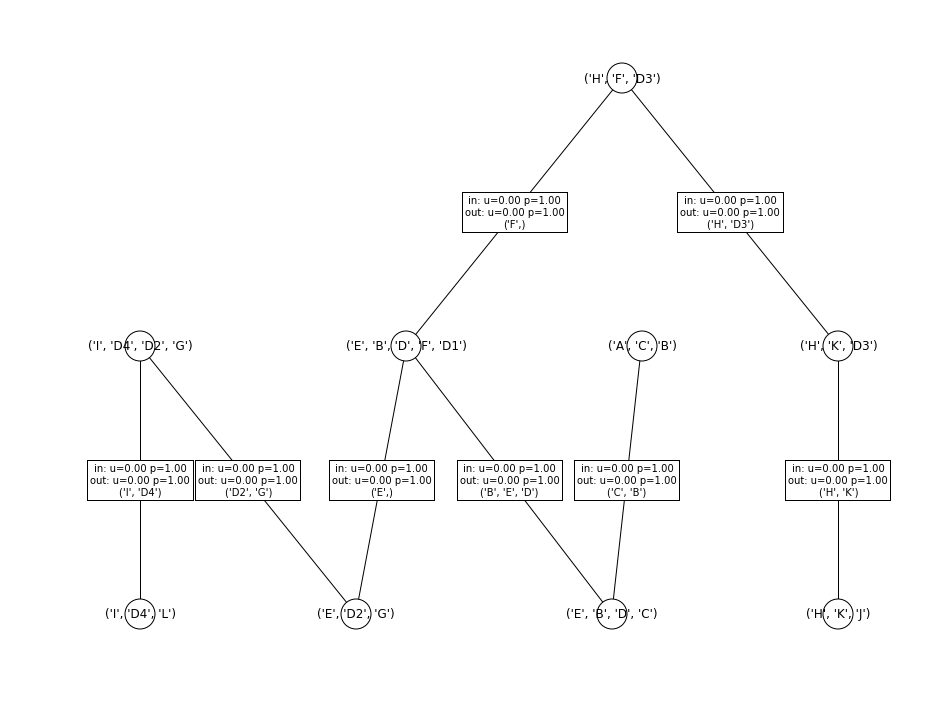

In [26]:
junction_tree = to_junctiontree(triangulated)
draw_graph(junction_tree)

In [27]:
cliques = [tuple(c) for c in nx.find_cliques(triangulated)]
print cliques
windows = {0: ['B'], 
           1: ['D1'],
           2: ['F', 'E'],
           3: ['D2'],
           4: [],
           5: ['D3'],
           6: ['G'],
           7: ['D4'],
           8: ['D', 'C', 'H', 'K', 'J', 'I', 'L', 'A']}
windows

[('A', 'C', 'B'), ('E', 'B', 'D', 'C'), ('E', 'B', 'D', 'F', 'D1'), ('E', 'D2', 'G'), ('I', 'D4', 'D2', 'G'), ('I', 'D4', 'L'), ('H', 'K', 'J'), ('H', 'K', 'D3'), ('H', 'F', 'D3')]


{0: ['B'],
 1: ['D1'],
 2: ['F', 'E'],
 3: ['D2'],
 4: [],
 5: ['D3'],
 6: ['G'],
 7: ['D4'],
 8: ['D', 'C', 'H', 'K', 'J', 'I', 'L', 'A']}

In [28]:
def get_cliques(ugraph, verbose=False):
    u = ugraph.copy()
    cliques = []
    separators = []
    variables = []
    i = [0]
    remaining_nodes = []
    elim_order = []
    for n, w in sorted(windows.items()):
        remaining_nodes.extend(w)
    #remaining = ['E','D','C','B','G','J','H','I','F','A']
    #print remaining
    
    # i = 0
    while remaining_nodes:
        proposed_clique = []
        eliminate = []
        separator = []
        
        selected = remaining_nodes[-1]
        family = fa(u,selected)
        proposed_clique.extend(family)
        eliminate.append(selected)
        #family.remove(selected)
        print 'Selected: ', selected
        #print 'Family: ',family
        for f in family:
            if f is selected:
                remaining_nodes.remove(f)
            elif set(nb(u, f)) <= set(family):
                #print 'Eliminating ',f
                remaining_nodes.remove(f)
                eliminate.append(f)
            else:
                #print 'f: ',f
                #print f, set(nb(u,f))
                separator.append(f)
        i.append(i[-1] + len(eliminate))
        if verbose:
            print 'Clique: ',proposed_clique
            print 'V: ', eliminate
            print 'S: ', separator
            print 'i: ', i[-1]
            print

        u.remove_nodes_from(eliminate)
        cliques.append(tuple(proposed_clique))
        separators.append(separator)
        variables.append(eliminate)

    i.remove(0)
    return cliques, separators, variables, i
    
                     
cliques, separators, variables, i = get_cliques(triangulated, True)
cliques

Selected:  A
Clique:  ['A', 'C', 'B']
V:  ['A']
S:  ['C', 'B']
i:  1

Selected:  L
Clique:  ['L', 'I', 'D4']
V:  ['L']
S:  ['I', 'D4']
i:  2

Selected:  I
Clique:  ['I', 'D4', 'D2', 'G']
V:  ['I', 'D4']
S:  ['D2', 'G']
i:  4

Selected:  J
Clique:  ['J', 'H', 'K']
V:  ['J']
S:  ['H', 'K']
i:  5

Selected:  K
Clique:  ['K', 'H', 'D3']
V:  ['K']
S:  ['H', 'D3']
i:  6

Selected:  H
Clique:  ['H', 'D3', 'F']
V:  ['H', 'D3']
S:  ['F']
i:  8

Selected:  C
Clique:  ['C', 'B', 'E', 'D']
V:  ['C']
S:  ['B', 'E', 'D']
i:  9

Selected:  D
Clique:  ['D', 'B', 'E', 'D1', 'F']
V:  ['D', 'B', 'D1', 'F']
S:  ['E']
i:  13

Selected:  G
Clique:  ['G', 'D2', 'E']
V:  ['G', 'D2', 'E']
S:  []
i:  16



[('A', 'C', 'B'),
 ('L', 'I', 'D4'),
 ('I', 'D4', 'D2', 'G'),
 ('J', 'H', 'K'),
 ('K', 'H', 'D3'),
 ('H', 'D3', 'F'),
 ('C', 'B', 'E', 'D'),
 ('D', 'B', 'E', 'D1', 'F'),
 ('G', 'D2', 'E')]

9 9 9
['C', 'B'] ('C', 'B', 'E', 'D')
['I', 'D4'] ('I', 'D4', 'D2', 'G')
['D2', 'G'] ('G', 'D2', 'E')
['H', 'K'] ('K', 'H', 'D3')
['H', 'D3'] ('H', 'D3', 'F')
['F'] ('D', 'B', 'E', 'D1', 'F')
['B', 'E', 'D'] ('D', 'B', 'E', 'D1', 'F')
['E'] ('G', 'D2', 'E')
junction_tree


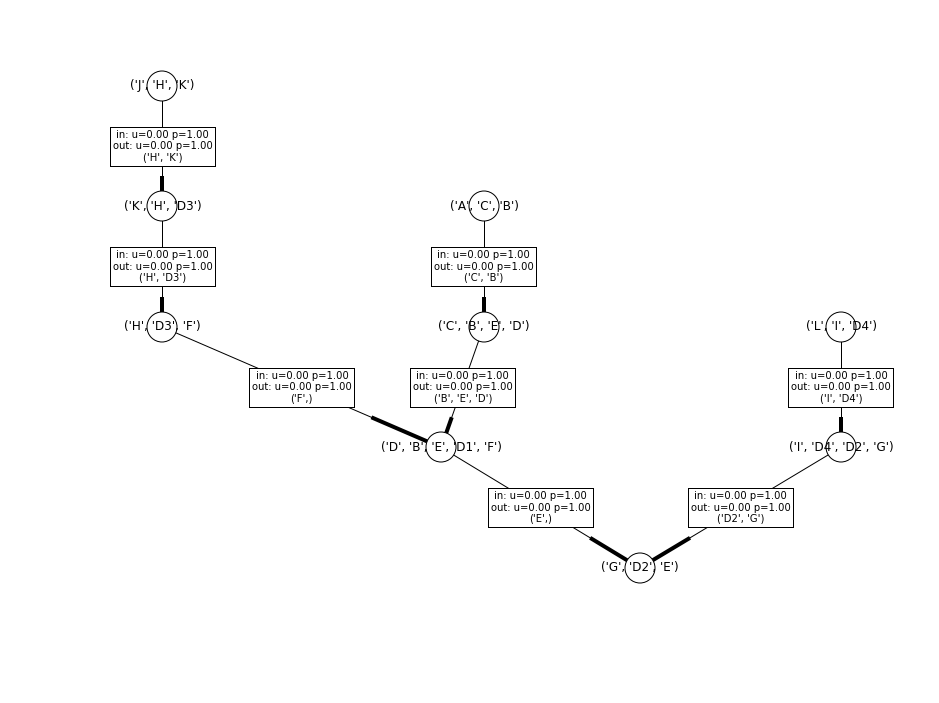

In [29]:
def connect_cliques(cliques, separators, i):
    jt = nx.DiGraph(type='junction_tree')
    jt.add_nodes_from(cliques, type='clique')
    print len(cliques), len(separators), len(i)
    for s in separators:
        for c in cliques:
            if set(s)<=set(c) and i[separators.index(s)] < i[cliques.index(c)]:
                print s, c
                jt.add_edge(cliques[separators.index(s)],c, separator=tuple(s), u_in=0, u_out=0, p_in=1, p_out=1)
    draw_graph(jt)
            
    
connect_cliques(cliques, separators, i)  

junction_tree


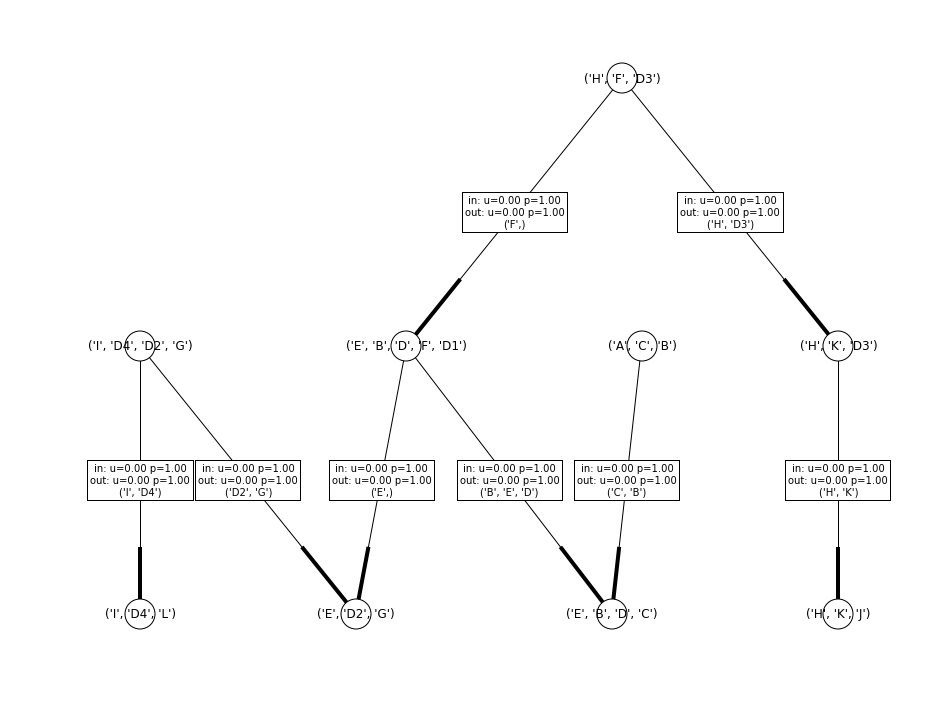

In [30]:
jt = nx.DiGraph(type='junction_tree')
jt.add_nodes_from(junction_tree.nodes(data=True))
jt.add_edges_from(junction_tree.edges(data=True))
draw_graph(jt)

In [31]:
order

{'A': 8,
 'B': 0,
 'C': 8,
 'D': 8,
 'D1': 1,
 'D2': 4,
 'D3': 5,
 'D4': 7,
 'E': 2,
 'F': 2,
 'G': 6,
 'H': 8,
 'I': 8,
 'J': 8,
 'K': 8,
 'L': 8}

junction_tree
junction_tree


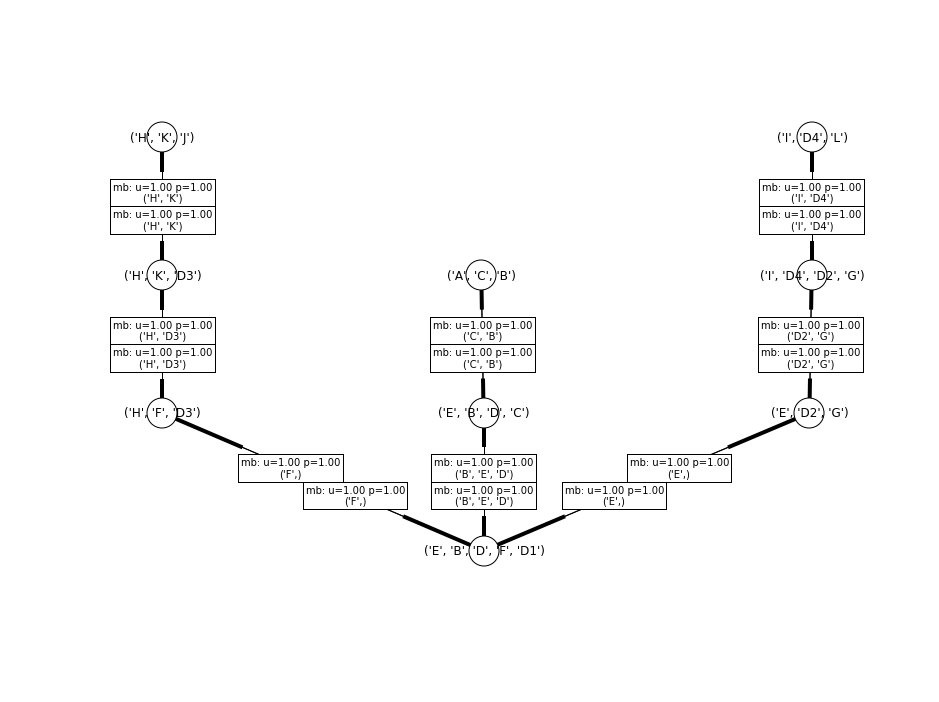

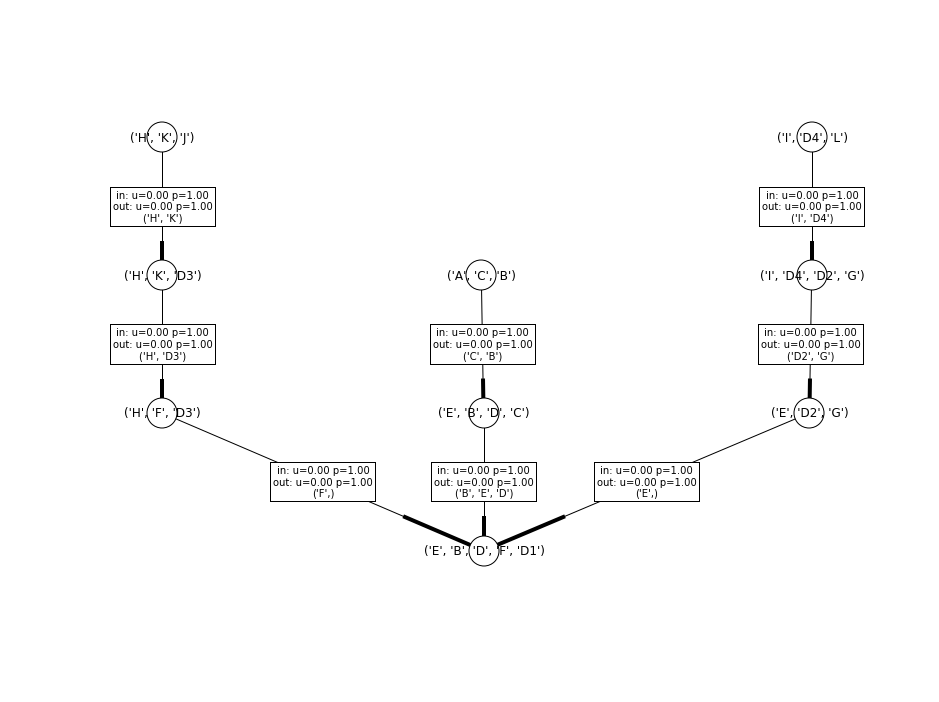

In [32]:
def is_root(dfs, root):
    pass
    

def find_root(junction_tree):
    roots = []
    w = windows.get(0)
    
    for root in junction_tree.nodes():
        x = len(junction_tree.nodes())
        cliques = list(junction_tree.nodes())
        cliques.remove(root)
        dfs = nx.dfs_tree(junction_tree, root)
        #print '---------'
        #print root
        path = list(nx.dfs_preorder_nodes(junction_tree, root))
        path.remove(root)
        for p in path:
            ci = tuple(*dfs.predecessors(p))
            cj = p
            s = junction_tree.get_edge_data(ci, cj)['separator']
            c_s = list(set(cj)-set(s))
            #print 'Separator: ', s
            #print 'C_s: ', c_s
            for si, c in product(list(s),list(c_s)):
                if not order.get(si) <= order.get(c):
                    x = x - 1
                    #print si, c, False
        if x == len(junction_tree.nodes()):
            roots.append(root)
    if roots:
        dfs = nx.dfs_tree(junction_tree, roots[0])
        dfs_r = nx.dfs_tree(junction_tree, roots[0]).reverse(copy=True)
        rooted_tree = nx.DiGraph(type='junction_tree')
        sjt = nx.DiGraph(type='strong_junction_tree')
        sjt.add_nodes_from(dfs.nodes(data=True), type='clique')
        rooted_tree.add_nodes_from(dfs.nodes(data=True), type='clique')
        for u, v in dfs.edges():
            sjt.add_edge(u,v, u_pot=1, p_pot=1, separator=tuple(set(u).intersection(set(v))))
        for u, v in dfs_r.edges():
            sjt.add_edge(u,v, u_pot =1, p_pot=1, separator=tuple(set(u).intersection(set(v))))
            rooted_tree.add_edge(u,v, junction_tree.get_edge_data(u,v))
        #sjt.add_edges_from(dfs.edges(data=True))
        #for u, v in junction_tree.edges():
            #junction_tree.add_edge(u, v, separator=tuple(set(u).intersection(set(v))), u_in=0, u_out=0, p_in=1, p_out=1)
        return roots, sjt, rooted_tree
    else:
        print 'Error: Found no strong root.'
        return roots
    
        
roots, strong_junction_tree, rooted_tree = find_root(junction_tree)
pos = nx.graphviz_layout(rooted_tree, prog='dot')
draw_graph(strong_junction_tree, pos)
draw_graph(rooted_tree, pos)

## Probability Propagation

### Evidence

In [33]:
def unstack_potentials(potentials):
    pots = []
    var = []
    for p in potentials:
        x = p
        if p.ndim != 1:
            for i in p.columns.names:
                x = x.stack(i)
        pots.append(x)
        var.append(set(x.index.names))
    return pots, var

In [81]:
def marginalize(var, table_list):
    '''Variable must exist in table.
    var is a list of variables to be summed out. '''
    tables, variables = unstack_potentials(table_list)
    result = []
    for t in tables:
        names = list(t.index.names)
        for v in var:
            if v in t.index.names:
                names.remove(v)
        if not len(names) == len(list(t.index.names)):
            print var
            print t.groupby(level=names).sum() == 1
            if (t.groupby(level=names).sum() == 1).all():
                result.append(1)
            else:
                result.append(t.groupby(level=names).sum())
        else:
            if (t == 1).all():
                result.append(1)
            else:
                result.append(t)
    return result


In [35]:
def introduce_evidence(table,evidence):
    tables, variables = unstack_potentials([table])
    t = tables[0]
    ev=[]
    index=[]
    
    for i in t.index.names:
        if evidence.has_key(i):
            index.append(i)
            ev.append(evidence.get(i))
    group = t.groupby(level=index)
    
    if len(ev)==1:
        return group.get_group(*ev)
    else:
        return group.get_group(tuple(ev))
    
#evidence = {'D':'T', 'C':'F'}

### Potentials

#### Operations

In [36]:
def mult(pot1,pot2):
    '''Tables must be aligned.'''
    if isinstance(pot1, int) or isinstance(pot2, int):
        return pot1*pot2
    elif pot1.ndim ==1 or pot2.ndim==1:
        return pot1*pot2
    else:
        t1 = pd.concat([pot1]*pot2.shape[0],axis=0, keys=pot2.index.values, names=pot2.index.names)
        t2 = pd.concat([pot2]*pot1.shape[0],axis=0, keys=pot1.index.values, names=pot1.index.names)
        return t1.sort()*t2.reorder_levels(t1.index.names).sort()

def div(pot1,pot2):
    '''Tables must be aligned.'''
    if isinstance(pot1, int) or isinstance(pot2, int):
        return pot1/pot2
    elif pot1.ndim ==1 or pot2.ndim==1:
        return pot1/pot2
    else:
        t1 = pd.concat([pot1]*pot2.shape[0],axis=0, keys=pot2.index.values, names=pot2.index.names)
        t2 = pd.concat([pot2]*pot1.shape[0],axis=0, keys=pot1.index.values, names=pot1.index.names)
        return t1.sort()/t2.reorder_levels(t1.index.names).sort()



In [37]:
def align(potentials, v, verbose=False):
    '''Potentials must have variables in common, and be unstacked.'''
    result = []
    for p in potentials:
        #print p
        #print
        if len(p.index.names)>len(v):
            #print 'DF'
            if len(v) == 1:
                result.append(p.unstack(level=v).sort(axis=1))
            else:
                result.append(p.unstack(level=v).sortlevel(axis=1))
        elif len(p.index.names)==len(v) and len(p.index.names)>1:
            #print 'Values'
            result.append(p.reorder_levels(v).sort_index())    
        else:
            #print 'S'
            result.append(p.sort_index())
    
    if verbose:
        print 'Verbose'
        for p in result:
            print p
            print
    
    return result

In [38]:
def multiply_potentials(potentials):
    n = 1
    pot = []
    for p in potentials:
        if isinstance(p, int):
            n = n * p
        else:
            pot.append(p)
            
    if n != 1:
        p = pot.pop()
        p = p * n
        pot.append(p)
            
    pots, var = unstack_potentials(pot)
    res = []
    #print var
    v = list(set.intersection(*var))
    
    while pots:
        #print pots
        if v:
            #print 'Easy!'
            aligned = align(pots, v)
            result = aligned.pop()
            for p in aligned:
                result = mult(result,p)
            return [result]
        else:
            #print 'Simplifying'
            pot1 = pots.pop()
            v1 = var.pop()
            common = [pot1]
            
            for x in var:
                if set.intersection(x, v1):
                    common.append(pots.pop(var.index(x)))
                    #print var.index(x)
                    var.remove(x)
            if len(common)==1:
                res.extend(common)
                if len(pots)==1:
                    res.extend(pots)
                    return res
            else:
                result = multiply_potentials(common)
                result_unstacked, result_var = unstack_potentials(result)
                pots.insert(0,*result_unstacked)
                var.insert(0,*result_var)
            v = list(set.intersection(*var))



In [60]:
def assign_potentials(junction_tree, verbose=False):    
    cliques = []
    nodes = []
    potentials = []
    assigned = []
    remaining = net.nodes()
    #print remaining
    for j in junction_tree.nodes():
        assigned_nodes = []
        p = []
        u = []
        for n, d in net.nodes(data=True):
            if not d['type'] == 'decision' and n in remaining: #and not n in assigned:
                #assigned.append(n)
                dom = net.predecessors(n)
                if d['type'] == 'chance':    
                    dom.append(n)
                    if set(dom) <= set(j):
                        assigned_nodes.append(n)
                        p.append(d['table'])
                        remaining.remove(n)
                elif d['type'] == 'utility':
                    if set(dom) <= set(j):
                        assigned_nodes.append(n)
                        u.append(d['table'])
                        remaining.remove(n)
            elif d['type'] == 'decision' and n in j:
                assigned_nodes.append(n)
                #remaining.remove(n)
        #print remaining
        u.extend(p)
        util_potential = multiply_potentials(u)
        prob_potential = multiply_potentials(p)
        cliques.append(j)
        nodes.append(assigned_nodes)
        potentials.append((prob_potential, util_potential))
        if verbose:
            print j
            print util_potential
            print
            print prob_potential
            print


        #print nodes
    potentials_dict=dict(zip(cliques,potentials))
    clique_dict=dict(zip(cliques,nodes))
    return clique_dict, potentials_dict

clique_dict, potential_dict = assign_potentials(strong_junction_tree)
clique_dict
#potential_dictionary

{('A', 'C', 'B'): ['A', 'C'],
 ('E', 'B', 'D', 'C'): ['E'],
 ('E', 'B', 'D', 'F', 'D1'): ['B', 'D', 'F', 'V1', 'D1'],
 ('E', 'D2', 'G'): ['G', 'D2'],
 ('H', 'F', 'D3'): ['H', 'V2', 'D3'],
 ('H', 'K', 'D3'): ['K', 'D3'],
 ('H', 'K', 'J'): ['J', 'V3'],
 ('I', 'D4', 'D2', 'G'): ['I', 'D4', 'D2'],
 ('I', 'D4', 'L'): ['L', 'V4', 'D4']}

In [40]:
def group_potentials(var, potentials):
    pots, pots_v = [], []
    for p in potentials:
        if isinstance(p, int):
            pots.append(p)
        else:
            pots_v.append(p)
    
    pots_v, v = unstack_potentials(pots_v)
    
    for p in pots_v:
        if var not in p.index.names:
            pots.append(p)
            pots_v.remove(p)
    #print pots
    #print pots_v
    
    return pots, pots_v    

In [41]:
def maxd(var, util_list, prob_list):
    ''' Handles a single decision, with its corresponding 
    utility potential and probability potential'''
    #print var, util_list
    util_result = []
    prob_result = []
    
    utils = util_list[:]
    probs = prob_list[:]
    
    for u in util_list:
        if isinstance(u, int):
            util_result.append(u)
            utils.remove(u)
    
    for p in prob_list:
        if isinstance(p, int):
            prob_result.append(p)
            probs.remove(p)
    
    utilities, util_var = unstack_potentials(utils)
    #print 'probs',probs
    if probs:
        probs, prob_var = unstack_potentials(probs)
    
        probabilities = []

        for p in probs:
            #print var, p.index.names
            #print var not in p.index.names
            if var not in p.index.names:
                prob_result.append(p)
            else:
                probabilities.append(p)
        #print '***'*3
        #print 'Prob\n',probabilities
        for u, p in izip(utilities, probabilities):
            #print u
            #print var
            names = list(u.index.names)
            maxed = []
            names.remove(var)

            if not len(names) == len(list(u.index.names)):
                groups = u.groupby(level=names)
                for n,g in groups:
                    maxed.append(g.argmax())
            else:
                print u

            util = u.loc[maxed].reset_index(level=var, drop=True)
            prob = p.loc[maxed].reset_index(level=var, drop=True)
            util_result.append(util)
            prob_result.append(prob)
    else:
        for u in utilities:
            names = list(u.index.names)
            maxed = []
            names.remove(var)

            if not len(names) == len(list(u.index.names)):
                groups = u.groupby(level=names)
                for n,g in groups:
                    maxed.append(g.argmax())
            else:
                print u

            util = u.loc[maxed].reset_index(level=var, drop=True)
            util_result.append(util)            
                        
    return util_result, prob_result

In [42]:
def collectR(junction_tree, rooted_tree, root):
    print '-----------'
    print root
    jt = junction_tree.copy()
    rt = rooted_tree.copy()
    #print junction_tree.in_edges(root, data=True)
    pot_dic = copy.deepcopy(potential_dict)
    path = list(nx.dfs_postorder_nodes(rooted_tree))
    print
    #path = list(nx.dfs_postorder_nodes(junction_tree, root))
    #path.reverse()
    print path
    #u = path.pop()
    while path:
        u = path.pop()
        #Projecting current cluster to variables in separator
        print '--------'
        v = tuple(*rooted_tree.successors(u)) #each clique only has one child
                    
        prob_pot_u, util_pot_u = pot_dic.get(u)
        
        if u is not root and rooted_tree.has_edge(u,v):
            print u, v
            for p in rooted_tree.predecessors(u):
                print 'Getting potentials from separators'
                su = jt.edge[p][u]['u_pot']
                sp = jt.edge[p][u]['p_pot']
                
                if not isinstance(sp, int):
                    prob_pot_u.extend(sp)
                else:
                    prob_pot_u.append(sp)
                    
                if not isinstance(su, int):
                    util_pot_u.extend(su)
                else:
                    util_pot_u.append(su)
                
            prob_pot_u = multiply_potentials(prob_pot_u)
            util_pot_u = multiply_potentials(util_pot_u)
                
            d = jt.get_edge_data(u, v)
            sum_out = list(set(u) - set(d['separator']))
            sum_out.sort(key=order.get, reverse=True)
            for ns in sum_out:
                if net.node[ns]['type'] == 'chance':
                    print 'Marginalize ', ns
                    prob_pot_u = marginalize([ns], prob_pot_u)
                    util_pot_u = marginalize([ns], util_pot_u)
                    #print util_pot_u
                    #print
                    #print prob_pot_u
                    #print
                elif net.node[ns]['type'] == 'decision':
                    print 'Marginalize ', ns
                    group_potentials(ns, util_pot_u)
                    util_pot_u, prob_pot_u = maxd(ns, util_pot_u, prob_pot_u)
                    #print util_pot_u
                    #print
                    #print prob_pot_u
                    #print
                elif net.node[ns]['type'] == 'utility':
                    print 'Marginalize ', ns
            jt[u][v]['u_pot']= util_pot_u
            jt[u][v]['p_pot']= prob_pot_u 
        else:
            print u
            
            
        #u = v
    #print '****'
    #print pot_dic.get(('E', 'B', 'D', 'F', 'D1'))
    return jt
    
    #draw_graph(jt, pos)

collect_jt = collectR(strong_junction_tree, rooted_tree, roots[0])

-----------
('E', 'B', 'D', 'F', 'D1')

[('E', 'B', 'D', 'F', 'D1'), ('E', 'D2', 'G'), ('I', 'D4', 'D2', 'G'), ('H', 'F', 'D3'), ('H', 'K', 'D3'), ('E', 'B', 'D', 'C'), ('A', 'C', 'B'), ('H', 'K', 'J'), ('I', 'D4', 'L')]
--------
('I', 'D4', 'L') ('I', 'D4', 'D2', 'G')
Marginalize  L
--------
('H', 'K', 'J') ('H', 'K', 'D3')
Marginalize  J
--------
('A', 'C', 'B') ('E', 'B', 'D', 'C')
Marginalize  A
--------
('E', 'B', 'D', 'C') ('E', 'B', 'D', 'F', 'D1')
Getting potentials from separators
Marginalize  C
--------
('H', 'K', 'D3') ('H', 'F', 'D3')
Getting potentials from separators
Marginalize  K
--------
('H', 'F', 'D3') ('E', 'B', 'D', 'F', 'D1')
Getting potentials from separators
Marginalize  H
Marginalize  D3
--------
('I', 'D4', 'D2', 'G') ('E', 'D2', 'G')
Getting potentials from separators
Marginalize  I
Marginalize  D4
--------
('E', 'D2', 'G') ('E', 'B', 'D', 'F', 'D1')
Getting potentials from separators
Marginalize  G
Marginalize  D2
--------
('E', 'B', 'D', 'F', 'D1')


In [43]:
def distributeR(junction_tree, rooted_tree, root):
    print '-----------'
    print root
    jt = junction_tree.copy()
    #rt = rooted_tree.copy()
    rt = rooted_tree.reverse(copy=True)
    pot_dic = copy.deepcopy(potential_dict)
    path = list(nx.dfs_postorder_nodes(rt, root))#.reverse()
    #path.reverse()
    print path
    
    root_separators = {}  
    while path:
        u = path.pop()
        #Projecting current cluster to variables in separator
        print '-'*60
        print u
        prob_pot_u, util_pot_u = pot_dic.get(u)
        
        v = tuple(*rt.predecessors(u))
        
        if u is root:
            for v1, u1, d1 in jt.in_edges(u, data=True):
                print v1
                prob = prob_pot_u[:]
                util = util_pot_u[:]  
                for v2, u2, d2 in jt.in_edges(u, data=True):
                    if not v1 == v2:
                        prob.extend(d2['p_pot'])
                        util.extend(d2['u_pot'])
                        
                prob = multiply_potentials(prob)
                util = multiply_potentials(util)
                #print util
                #print prob
                
                sum_out = list(set(u) - set(d1['separator']))
                sum_out.sort(key=order.get, reverse=True)
                for ns in sum_out:
                    if net.node[ns]['type'] == 'chance':
                        print 'Marginalize ', ns
                        prob = marginalize([ns], prob)
                        util = marginalize([ns], util)
                        #print util
                        #print
                        #print prob
                        #print
                    elif net.node[ns]['type'] == 'decision':
                        print 'Marginalize ', ns
                        ut, u_ns = group_potentials(ns, util)
                        pt, p_ns = group_potentials(ns, prob)
                        
                        util, prob = maxd(ns, u_ns, p_ns)
                        util.extend(ut)
                        prob.extend(pt)
                        #print util
                        #print
                        #print prob
                        #print
                    elif net.node[ns]['type'] == 'utility':
                        print 'Marginalize ', ns
                #print util
                #print prob
                jt[root][v1]['u_pot']= util
                jt[root][v1]['p_pot']= prob                 
        else:
            #v = tuple(*rooted_tree.successors(u)) #each clique only has one child
            if rt.successors(u):
                for p in rt.predecessors(u):
                    print 'Getting potentials from separators'
                    su = jt.edge[p][u]['u_pot']
                    sp = jt.edge[p][u]['p_pot']

                    if not isinstance(sp, int):
                        prob_pot_u.extend(sp)
                    else:
                        prob_pot_u.append(sp)

                    if not isinstance(su, int):
                        util_pot_u.extend(su)
                    else:
                        util_pot_u.append(su)

                prob_pot_u = multiply_potentials(prob_pot_u)
                util_pot_u = multiply_potentials(util_pot_u)

                for v in rt.successors(u):
                    prob = prob_pot_u[:]
                    util = util_pot_u[:]

                    d = jt.get_edge_data(u, v)
                    sum_out = list(set(u) - set(d['separator']))
                    sum_out.sort(key=order.get, reverse=True)
                    for ns in sum_out:
                        if net.node[ns]['type'] == 'chance':
                            print 'Marginalize ', ns
                            prob = marginalize([ns], prob)
                            util = marginalize([ns], util)
                            #print util_pot_u
                            #print
                            #print prob_pot_u
                            #print
                        elif net.node[ns]['type'] == 'decision':
                            print 'Marginalize ', ns
                            ut, u_ns = group_potentials(ns, util)
                            pt, p_ns = group_potentials(ns, prob)

                            util, prob = maxd(ns, u_ns, p_ns)
                            util.extend(ut)
                            prob.extend(pt)
                            #print util_pot_u
                            #print
                            #print prob_pot_u
                            #print
                        elif net.node[ns]['type'] == 'utility':
                            print 'Marginalize ', ns
                    jt[u][v]['u_pot']= util
                    jt[u][v]['p_pot']= prob 
    return jt
        
jt_distr = distributeR(collect_jt, rooted_tree, roots[0])

-----------
('E', 'B', 'D', 'F', 'D1')
[('I', 'D4', 'L'), ('I', 'D4', 'D2', 'G'), ('E', 'D2', 'G'), ('A', 'C', 'B'), ('E', 'B', 'D', 'C'), ('H', 'K', 'J'), ('H', 'K', 'D3'), ('H', 'F', 'D3'), ('E', 'B', 'D', 'F', 'D1')]
------------------------------------------------------------
('E', 'B', 'D', 'F', 'D1')
('E', 'D2', 'G')
Marginalize  D
Marginalize  F
Marginalize  D1
Marginalize  B
('E', 'B', 'D', 'C')
Marginalize  F
Marginalize  D1
('H', 'F', 'D3')
Marginalize  D
Marginalize  E
Marginalize  D1
Marginalize  B
------------------------------------------------------------
('H', 'F', 'D3')
Getting potentials from separators
Marginalize  F
------------------------------------------------------------
('H', 'K', 'D3')
Getting potentials from separators
Marginalize  D3
------------------------------------------------------------
('H', 'K', 'J')
------------------------------------------------------------
('E', 'B', 'D', 'C')
Getting potentials from separators
Marginalize  D
Marginalize  E
---

In [83]:
def query(var, junction_tree):
    pot_dic = copy.deepcopy(potential_dict)
    jt = junction_tree.copy()
    #print clique_dict
    cliques = []
    print
    for c, d in clique_dict.items():
        if var in d:
            cliques.append(c)
            break
            
    clique = cliques.pop()
    in_edges = jt.in_edges(clique, data=True)
    print clique
    prob, util = pot_dic.get(clique)
    #print list(jt.in_edges(clique))
    for u, v, d in jt.in_edges(clique, data=True):
        #print u
        prob.extend(d['p_pot'])
        util.extend(d['u_pot'])
                        
    prob = multiply_potentials(prob)
    util = multiply_potentials(util)
    
    sum_out = list(clique)
    sum_out.remove(var)
    sum_out.sort(key=order.get, reverse=True)
    for ns in sum_out:
        if net.node[ns]['type'] == 'chance':
            print 'Marginalize ', ns
            print prob
            print
            print util
            print
            prob = marginalize([ns], prob)
            util = marginalize([ns], util)
            print prob
            print
            print util
            print
        elif net.node[ns]['type'] == 'decision':
            print 'Marginalize ', ns
            print prob
            print
            print util
            print
            
            ut, u_ns = group_potentials(ns, util)
            pt, p_ns = group_potentials(ns, prob)

            util, prob = maxd(ns, u_ns, p_ns)
            util.extend(ut)
            prob.extend(pt)
            
        elif net.node[ns]['type'] == 'utility':
            print 'Marginalize ', ns

    print prob
    print util
    
    
query('B', jt_distr)


('E', 'B', 'D', 'F', 'D1')
Marginalize  D
[B              F                   T        
D              F         T         F       T
F D1 E                                      
F d1 F  0.148181  0.026100  0.099938  0.0390
     T  0.114319  0.033900  0.087562  0.0610
  d2 F  0.158766  0.021750  0.079950  0.0468
     T  0.122484  0.028250  0.070050  0.0732
T d1 F  0.049394  0.039150  0.033313  0.0585
     T  0.038106  0.050850  0.029187  0.0915
  d2 F  0.052922  0.032625  0.026650  0.0702
     T  0.040828  0.042375  0.023350  0.1098]

[E                      F              T
D1 F B D                               
d1 F F F  1000003.944023  772586.975672
       T   176136.339375  229102.386750
     T F   674430.092578  591763.355156
       T   263192.231250  412249.132500
   T F F   296728.631172  229247.771594
       T   235190.199375  305914.362750
     T F   200121.928906  175592.437812
       T   351433.631250  550465.372500
d2 F F F   535716.398584  413885.879824
       T    73390.